<a href="https://colab.research.google.com/github/VindhyaSRajan/Master-s-Thesis/blob/Amazon/CorEx_Meta_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mounting the drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

##All Imports go here but first, installations

In [0]:
!pip install corextopic
!pip install joblib
!pip install pyLDAvis

In [0]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt
import pandas as pd

import string

from corextopic import corextopic as ct
from corextopic import vis_topic as vt 
from sklearn.feature_extraction.text import CountVectorizer



pd.set_option('display.max_colwidth', -1)  # to view entire text in any column
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
import gzip
from pprint import pprint

from bs4 import BeautifulSoup
import nltk
from nltk import FreqDist
nltk.download('stopwords') 
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer  # alternative lemmatizer
# lemma = WordNetLemmatizer()

import spacy
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim   # for visualizing found topics

import os


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning) 
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
import pandas as pd
import gzip
#import turicreate as tc

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')


In [0]:
df = getDF('/gdrive/My Drive/Amazon_data/meta_Patio_Lawn_and_Garden.json.gz')
df.head()
print(df.columns)
df = df[['category']]
df.sample(5)

Index(['category', 'tech1', 'description', 'title', 'also_buy', 'brand',
       'feature', 'rank', 'main_cat', 'date', 'price', 'asin', 'image',
       'also_view', 'similar_item', 'details', 'fit', 'tech2'],
      dtype='object')


,category
83417,"[Patio, Lawn & Garden, Gardening & Lawn Care, Plants, Seeds & Bulbs]"
260920,"[Patio, Lawn & Garden, Outdoor Dcor, Backyard Birding & Wildlife, Birds, Food, Mealworms]"
111941,"[Patio, Lawn & Garden, Patio Furniture & Accessories, Patio Seating, Porch Swings]"
119794,"[Patio, Lawn & Garden, Outdoor Dcor, Flags]"
120041,"[Patio, Lawn & Garden, Outdoor Dcor, Flags]"


In [0]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)  # to view entire text in any column
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
import gzip
from pprint import pprint

from bs4 import BeautifulSoup
import nltk
from nltk import FreqDist
nltk.download('stopwords') 
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer  # alternative lemmatizer
# lemma = WordNetLemmatizer()

import spacy
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim   # for visualizing found topics

import os


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
df = df.dropna(subset = ['category'])
df.shape[0]

279697

In [0]:
df['category'] = df['category'].astype(str)

In [0]:
# functions for text cleaning and pre-processing

def chk_has_html(rev_df,print_all=True):
    # check for review text that has tags such as &#34;
    # rev_df: e.g. df['reviewText']
    html_num = defaultdict(int)
    review_w_html = []
    for idx, text in enumerate(rev_df):
        strange_text = re.findall(r'&#\d+;',text)
        if len(strange_text) > 1:
            for t in strange_text:
                html_num[t] += 1
            review_w_html.append(text)
    
    if print_all == True:
        print(sorted(html_num.items(), key = lambda kv:(kv[1], kv[0]), reverse=True))     
    return html_num

def chk_html_num(rev_df,tag):
    # prints reviews that contain the special HTML numbers specified by tag
    # tag: HTML numbers with pattern r'&#\d+;'
    for idx, text in enumerate(rev_df):
        if tag in text:
            print(idx, text, '\n')

def convert_html(rev): 
    # replace the html tags by the corresponding symbol using HTML_MAP
    html_entity = re.findall(r'&#\d+;',rev)
    rev_new = rev
    if len(html_entity) > 0:
        for t in html_entity:
            rev_new = rev_new.replace(t,HTML_MAP[t])
    return rev_new

def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

punc_char = set(string.punctuation)

def remove_punctuation(rev):
    # remove punctuation from the input string rev
    return ''.join([ch for ch in rev if ch not in punc_char])

stop_words = stopwords.words('english')
stop_words.extend(['would','dont','cant','should','it.','(',')','-','one','!','"',',','.'])  

def remove_stopwords(rev):
    # rev is a review text, one string
    rev_new = " ".join([i for i in rev.split() if i not in stop_words])
    return rev_new

nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(rev): 
    # lemmatize input string rev, i.e. reduce all forms of a word to the lemma
    doc = nlp(" ".join(rev.split()))
    return " ".join([token.lemma_ for token in doc])

def lemmatization_tag(rev, tags = ['NOUN', 'ADJ']): # filter noun and adjective
    doc = nlp(" ".join(rev.split()))
    return " ".join([token.lemma_ for token in doc if token.pos_ in tags])

def remove_num(s):
    # s is a string, e.g. an entire review text
    return ''.join([i for i in s if not i.isdigit()])

In [0]:
df.loc[:,'cat_no_html'] = df['category'].apply(remove_html_tags)
df.loc[:,'cat_no_html'] = df['cat_no_html'].apply(remove_html_tags)
print(df['cat_no_html'].sample(5))
df.loc[:,'cat_no_punc'] = [remove_punctuation(r) for r in df['cat_no_html']]
print('Punctuation removed  \n')
df.loc[:,'cat_no_stopwords'] = [remove_stopwords(r.lower()) for r in df['cat_no_html']]
print('Stopwords Removed \n')
#freq_words(df['cat_no_stopwords'])
# lemmatize, this is a relatively slow preprocessing step 
df.loc[:,'cat_lemmatized'] = df['cat_no_stopwords'].apply(lemmatization)
print('Lemmatisation done \n')
# run remove stop words again because the lemmatization process generates more stop words
df.loc[:,'cat_lemmatized'] = df['cat_lemmatized'].apply(remove_stopwords)
print('Stopwords now removed again after lemmatisation \n')
# remove numbers
df.loc[:, 'cat_lemmatized'] = df['cat_lemmatized'].apply(remove_num)


157768    ['Patio, Lawn & Garden', 'Grills & Outdoor Cooking', 'Outdoor Cooking Tools & Accessories', 'Grilling & Barbecue Utensils']
39330     ['Patio, Lawn & Garden', 'Patio Furniture & Accessories', 'Canopies, Gazebos & Pergolas']                                  
278369    ['Patio, Lawn & Garden', 'Pools, Hot Tubs & Supplies', 'Parts & Accessories', 'Safety Products']                           
274445    ['Patio, Lawn & Garden', 'Outdoor Dcor', 'Flags']                                                                          
228030    ['Patio, Lawn & Garden', 'Outdoor Power Tools', 'Wood Chippers, Shredders, & Mulchers']                                    
Name: cat_no_html, dtype: object
Punctuation removed  

Stopwords Removed 

Lemmatisation done 

Stopwords now removed again after lemmatisation 



KeyError: ignored

In [0]:
print(df['category'].sample(n=3, random_state = 0),'\n')
print(df['cat_no_stopwords'].sample(n=3, random_state = 0),'\n')
print(df['cat_lemmatized'].sample(n=3, random_state = 0),'\n')


56350     ['Patio, Lawn & Garden', 'Outdoor Dcor', 'Garden Sculptures & Statues', 'Outdoor Statues']        
68050     ['Patio, Lawn & Garden', 'Outdoor Dcor', 'Backyard Birding & Wildlife', 'Birds', 'Feeders']       
196510    ['Patio, Lawn & Garden', 'Grills & Outdoor Cooking', 'Grills', 'Gas Grills', 'Natural Gas Grills']
Name: category, dtype: object 

56350     ['patio, lawn & garden', 'outdoor dcor', 'garden sculptures & statues', 'outdoor statues']        
68050     ['patio, lawn & garden', 'outdoor dcor', 'backyard birding & wildlife', 'birds', 'feeders']       
196510    ['patio, lawn & garden', 'grills & outdoor cooking', 'grills', 'gas grills', 'natural gas grills']
Name: cat_no_stopwords, dtype: object 

56350     [ ' patio lawn & garden ' ' outdoor dcor ' ' garden sculpture & statue ' ' outdoor statue ' ]        
68050     [ ' patio lawn & garden ' ' outdoor dcor ' ' backyard birding & wildlife ' ' bird ' ' feeder ' ]     
196510    [ ' patio lawn & garden ' ' grill & outd

In [0]:
df[['category','cat_no_html', 'cat_lemmatized']].to_csv('/gdrive/My Drive/Amazon_data/meta_lawn_processed.csv')

##Reading the already pre-processed data

In [0]:
df = pd.read_csv('/gdrive/My Drive/Amazon_data/meta_lawn_processed.csv')
df.head()
df.shape

(279697, 4)

In [0]:
df['cat_lemmatized'] = df['cat_lemmatized'].astype(str)

##Building Dictionary,Term-Doc Matrix

In [0]:
#Amazon Review Data
# number of asins, number of associated reviews for each rating
review_cnts = df.groupby('overall').agg({'review_lemmatized':'count'}).sort_values(by = 'review_lemmatized', ascending = False)
review_cnts = review_cnts.reset_index()
review_cnts = review_cnts.rename({'review_lemmatized':'reviewCnt'}, axis = 'columns')
print('Top 10 most reviewed:\n', review_cnts.head(10),'\n')
print(review_cnts.reviewCnt.describe())
plt.figure(figsize=(8,10))


Top 10 most reviewed:
    overall  reviewCnt
0  5.0      57019    
1  4.0      18352    
2  1.0      11305    
3  3.0      7741     
4  2.0      5524      

count    5.000000    
mean     19988.200000
std      21263.597125
min      5524.000000 
25%      7741.000000 
50%      11305.000000
75%      18352.000000
max      57019.000000
Name: reviewCnt, dtype: float64


<Figure size 576x720 with 0 Axes>

<Figure size 576x720 with 0 Axes>

In [0]:
#Converting the DF to list to feed to the CorEx Model
dfToList = df['cat_lemmatized'].tolist()

dfList = list(df['cat_lemmatized'])

dfValues = df['cat_lemmatized'].values
#print(dfList)
print(dfValues)

["[ ' patio lawn & garden ' ' outdoor power tool ' ' replacement part & accessory ' ' lawn mower part & accessory ' ]"
 "[ ' patio lawn & garden ' ' outdoor dcor ' ' garden sculpture & statue ' ' decorative stone ' ]"
 "[ ' patio lawn & garden ' ' gardening & lawn care ' ' plant seed & bulb ' ]"
 ...
 "[ ' patio lawn & garden ' ' farm & ranch ' ' agricultural & construction machinery ' ' part & accessory ' ' spare & replacement part ' ]"
 "[ ' patio lawn & garden ' ' farm & ranch ' ' agricultural & construction machinery ' ' part & accessory ' ' spare & replacement part ' ]"
 "[ ' patio lawn & garden ' ' patio furniture & accessory ' ' umbrella & shade ' ' umbrella ' ]"]


In [0]:
# Transform Amazon Reviews data into a sparse matrix
vectorizer = CountVectorizer(stop_words='english', max_features=20000,binary = True)
doc_word = vectorizer.fit_transform(df['cat_lemmatized'].values.astype('U')) #Learn the vocabulary dictionary and return term-document matrix.
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

(279697, 2208)

In [0]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))

In [0]:
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words    = [word for ind,word in enumerate(words) if not word.isdigit()]

doc_word.shape # n_docs x m_words

(279697, 2208)

##Training the CorEx Topic Model

In [0]:
# Train the CorEx topic model with 10 topics
topic_model = ct.Corex(n_hidden=10, words=words, max_iter=500, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

In [0]:
# Print a single topic from CorEx topic model. This model is trained on the Amazon Garden and Lawn Products
topic_model.get_topics(topic=7, n_words=10)

[('water', 0.27992647622646005),
 ('equipment', 0.1462205468699007),
 ('pond', 0.0641669063615212),
 ('hose', 0.03955357672130647),
 ('automatic', 0.03927024310181976),
 ('irrigation', 0.028850666449103234),
 ('testing', 0.026666231592553248),
 ('connector', 0.018678798233932932),
 ('circulation', 0.01787910739597457),
 ('sprinkler', 0.016410507324117172)]

In [0]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: gardening,care,plant,bulb,seed,planter,pot,container,flower,soil
1: pool,hot,tub,supply,cleaning,chemical,instrument,product,weather,thermometer
2: dcor,outdoor,accessory,flag,statue,sculpture,doormat,chime,control,yard
3: power,tool,mower,mow,generator,portable,chainsaw,pressure,washer,stre
4: farm,ranch,backyard,birding,wildlife,bird,agricultural,construction,machinery,spare
5: grill,cooking,utensil,grilling,barbecue,snow,removal,burner,blower,plate
6: furniture,seat,umbrella,chair,shade,cushion,table,canopy,pergola,gazebos
7: water,equipment,pond,hose,automatic,irrigation,testing,connector,circulation,sprinkler
8: hand,scissor,shear,pruner,spade,trowel,shovel,test,axis,manual
9: replacement,protective,glove,gear,wheelbarrow,pad,knee,kneel,apron,workseat


In [0]:
topic_model.get_topics(topic=5, n_words=10, print_words=False)

[(883, 0.29094289633769976),
 (431, 0.2904476769095286),
 (2064, 0.04654133885937111),
 (884, 0.04652649635419393),
 (139, 0.04650595844123529),
 (1767, 0.02105650410201877),
 (1576, 0.020999202735327332),
 (251, 0.019668204208130452),
 (202, 0.016813966103308688),
 (1420, 0.01665730281438869)]

In [0]:
print(topic_model.clusters)
print(topic_model.clusters.shape) # m_words

[4 8 5 ... 4 4 5]
(2208,)


In [0]:
# Print a single topic from CorEx topic model
topic_model.get_top_docs(topic=7, n_docs=10, sort_by='log_prob')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(52563, 0.0),
 (178806, 0.0),
 (42221, 0.0),
 (42222, 0.0),
 (42225, 0.0),
 (42240, 0.0),
 (42241, 0.0),
 (93740, 0.0),
 (42243, 0.0),
 (111603, 0.0)]

In [0]:
print(topic_model.p_y_given_x.shape) # n_docs x k_topics

(279697, 10)


In [0]:
print(topic_model.labels.shape) # n_docs x k_topics

(279697, 10)


##Total Corelation and Model Selection

In [0]:
#Here trying to implement what the paper proposes. Total correlation is the measure which CorEx maximize when constructing the topic model. It can be accessed through tc and is reported in nats.
topic_model.tc 

6.286875417453791

In [0]:
topic_model.tcs.shape # k_topics

(10,)

In [0]:
print(np.sum(topic_model.tcs))
print(topic_model.tc)

6.286875417453791
6.286875417453791


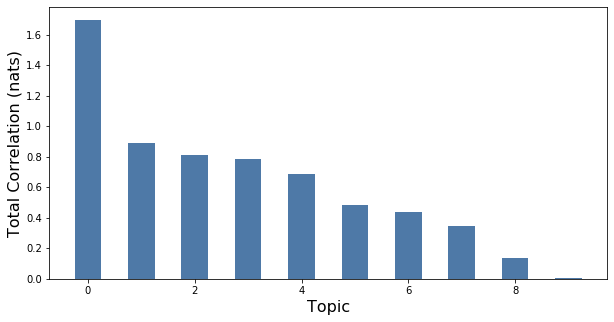

In [0]:
#Selecting number of topics:Choosing from the data visualised
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
#plt.savefig('Distribution of TCs for each topic', dpi=600)

##Pointwise Document TC

In [0]:
topic_model.log_z.shape # n_docs x k_topics

(279697, 10)

In [0]:
print(np.mean(topic_model.log_z, axis=0)) #The pointwise total correlations in log_z represent the correlations within an individual document explained by a particular topic. These correlations have been used to measure how "surprising" documents are with respect to given topics
print(topic_model.tcs)

[1.69738781 0.89351488 0.81217524 0.78491838 0.68869838 0.48607448
 0.43508857 0.34637922 0.13434364 0.00829481]
[1.69738781 0.89351488 0.81217524 0.78491838 0.68869838 0.48607448
 0.43508857 0.34637922 0.13434364 0.00829481]


##Now adding some hierarchy to the Topic Model

In [0]:
# Train a second layer to the topic model
tm_layer2 = ct.Corex(n_hidden=10)
tm_layer2.fit(topic_model.labels);

# Train a third layer to the topic model
tm_layer3 = ct.Corex(n_hidden=1)
tm_layer3.fit(tm_layer2.labels);

In [0]:
vt.vis_hierarchy([topic_model, tm_layer2, tm_layer3], column_label=words, max_edges=200, prefix='topic-model-example')


##Introducing Anchoring in the semi-supervised topic model

In [0]:
# Anchor one word to the eighth topic
anchor_words = ['gardening']

In [0]:
# Anchor the word 'shipping' to the seventh topic
anchored_topic_model = ct.Corex(n_hidden=50, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [0]:
topic_words,_ = zip(*anchored_topic_model.get_topics(topic=9))
print('8: ' + ','.join(topic_words))

8: supply,pool,hot,tub,ranch,farm,agricultural,cleaning,machinery,construction


In [0]:
# Anchor 'electric' and 'electronic' to first topic, 'birds' and 'garden' to second topic, so on...
anchor_words = [['gardening', 'tool'], ['pool', 'tub'], ['outdoor', 'accessory'], ['replacement', 'gear']]

anchored_topic_model = ct.Corex(n_hidden=50, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [0]:
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words))

0: gardening,tool,care,dcor,flag,doormat,chime,fountain,grass,mailbox
1: pool,tub,hot,supply,chemical,cleaning,product,spa,medium,filter
2: outdoor,accessory,plant,bulb,seed,flower,control,vegetable,hand,repellent
3: replacement,power,mower,mow,gear,chainsaw,trim,stre,washer,pressure


In [0]:
# Anchor with single words and groups of words
anchor_words = ['gardening', ['gardening', 'tool'], ['gardening', 'shovel'], 'flower']

anchored_topic_model = ct.Corex(n_hidden=50, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [0]:
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words))

0: gardening,care,plant,bulb,seed,planter,pot,container,soil,fertilizer
1: gardening,tool,dcor,flag,doormat,chime,fountain,grass,freestande,weathervane
2: gardening,outdoor,shovel
3: flower,bib,collar,mid,repellant,styling,thigh,throat,trench,vest


In [0]:
vt.vis_rep(topic_model, column_label=words, prefix='./twenty')

In [0]:
%pwd
%cd /content/
%pwd

/content


'/content'

In [0]:
#Saving the CorEx topics generated in a file
import sys
import csv
import os
with open("corex_topic_meta.txt","w+") as file:
     for n in range(len(anchor_words)):
         topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
         #print('{}: '.format(n) + ','.join(topic_words))
         file.write('{}: '.format(n) + ','.join(topic_words)+'\n')